In [1]:
import torch
import torch.nn as nn
import os
import sys
import numpy as np
import argparse
import yaml
from matplotlib import pyplot as plt
sys.path.append('../dsc/')
sys.path.append("../..")
sys.path.append("../../tslib/src/")
sys.path.append("../../tslib/")
sys.path.append(os.getcwd())
from dsc_model import DSCModel
from bert2bert import Bert2BertSynCtrl
from transformers import BertConfig
from src import tsUtils
import pandas as pd
from src.synthcontrol.syntheticControl import RobustSyntheticControl
from src.synthcontrol.multisyntheticControl import MultiRobustSyntheticControl
%load_ext autoreload
%autoreload 2

In [2]:
# Pretraining Asthma dataset
datapath = f'../datasets/asthma_placebo/'
config_path = '../exp_configs/asthma/config.yaml'
config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
op_path = f'../logs_dir/asthma_control/'
if not(os.path.exists(op_path)):
    os.mkdir(op_path)
random_seed = 0
target_index = 0
lowrank = True
device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
classes = None
config_model = BertConfig(hidden_size = config['hidden_size'],
                        num_hidden_layers = config['n_layers'],
                        num_attention_heads = config['n_heads'],
                        intermediate_size = 4*config['hidden_size'],
                        vocab_size = 0,
                        max_position_embeddings = 0,
                        output_hidden_states = True,
                        )

config_model.add_syn_ctrl_config(K=config['K'],
                                pre_int_len=config['pre_int_len'],
                                post_int_len=config['post_int_len'],
                                feature_dim=config['feature_dim'],
                                time_range=config['time_range'],
                                seq_range=config['seq_range'],
                                cont_dim=config['cont_dim'],
                                discrete_dim=config['discrete_dim'],
                                classes = classes)
model = Bert2BertSynCtrl(config_model, random_seed)
model = model.to(device)
dscmodel = DSCModel(model,
                    config,
                    op_path,
                    target_index,
                    random_seed,
                    datapath,
                    device,
                    lowrank = True,
                    classes=None)
dscmodel.pretrain(checkpoint_pretrain = None)

KeyboardInterrupt: 

In [2]:
#Finetuning Asthma dataset

interv_times = [7,15]

for interv_time in interv_times:
    datapath = f'../datasets/asthma_placebo/'
    config_path = '../exp_configs/asthma/config.yaml'
    config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
    model_path = f'../logs_dir/asthma_control/pretrain/model.pth'
    op_path = f'../logs_dir/asthma_control_{interv_time}/'
    if not(os.path.exists(op_path)):
        os.mkdir(op_path)
    random_seed = 0
    target_index = 0
    lowrank = True
    device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
    classes = None
    config_model = BertConfig(hidden_size = config['hidden_size'],
                            num_hidden_layers = config['n_layers'],
                            num_attention_heads = config['n_heads'],
                            intermediate_size = 4*config['hidden_size'],
                            vocab_size = 0,
                            max_position_embeddings = 0,
                            output_hidden_states = True,
                            )

    config_model.add_syn_ctrl_config(K=config['K'],
                                    pre_int_len=config['pre_int_len'],
                                    post_int_len=config['post_int_len'],
                                    feature_dim=config['feature_dim'],
                                    time_range=config['time_range'],
                                    seq_range=config['seq_range'],
                                    cont_dim=config['cont_dim'],
                                    discrete_dim=config['discrete_dim'],
                                    classes = classes)
    model = Bert2BertSynCtrl(config_model, random_seed)
    model = model.to(device)
    dscmodel = DSCModel(model,
                        config,
                        op_path,
                        target_index,
                        random_seed,
                        datapath,
                        device,
                        lowrank = True,
                        classes=None)
    dscmodel.load_model_from_checkpoint(model_path)
    dscmodel.fit(interv_time,pretrain=False)

Modifying K
Low rank conversion done
Fitting model on target unit
Iteration:0	Loss_mean:0.011390503495931625	Loss_std:0.0
Iteration:100	Loss_mean:0.0014387560904651764	Loss_std:0.0013078196057385084
Iteration:200	Loss_mean:0.0004749952741713059	Loss_std:0.0004630502512673258
Iteration:300	Loss_mean:0.0003761650508454295	Loss_std:0.0004099206307869222
Iteration:400	Loss_mean:0.00026303647181975977	Loss_std:0.00029691807450300345
Iteration:500	Loss_mean:0.0003704741684529722	Loss_std:0.0004241986922008731
Iteration:600	Loss_mean:0.00023757014528143826	Loss_std:0.0002848603761378654
Iteration:700	Loss_mean:0.00019913287248527923	Loss_std:0.00023158073467474156
Iteration:800	Loss_mean:0.00016335499596607407	Loss_std:0.00018196968874149334
Iteration:900	Loss_mean:0.0001556519023824876	Loss_std:0.0001691534849499482
Iteration:1000	Loss_mean:0.00018423409510432976	Loss_std:0.00017154380536594434
Iteration:1100	Loss_mean:0.0001205886162972547	Loss_std:0.00012502412794724162
Iteration:1200	Loss

In [3]:
data_dir = f'../datasets/asthma_placebo/'
mask = np.load(data_dir+'mask.npy')
data = np.load(data_dir+'data.npy')
data[np.nonzero(mask)] = 0
prob_missing = np.sum(mask)/(data.shape[0]*data.shape[1]*data.shape[2])
prob_missing_rsc = np.sum(mask[:,:,0])/(data.shape[0]*data.shape[1])
interv = [7,15]

mrsc_preds = []
rsc_preds = []
rsc_pre_preds = []
mrsc_pre_preds = []
actual = []


for TrainingEnd in interv:
    all_observations=[]
    for i in range(data.shape[2]):
        all_observations.append(data[:,:,i])

    N = all_observations[0].shape[0] -1
    T = all_observations[0].shape[1]
    print(N,T)
    trainingDict_alls = [{} for i in range(data.shape[2])]
    testDict_alls = [{} for i in range(data.shape[2])]



    for i in range(0, N+1):
        for j in range(data.shape[2]):
            trainingDict_alls[j].update({str(i): all_observations[j][i, 0:TrainingEnd]})
            testDict_alls[j].update({str(i): all_observations[j][i, TrainingEnd:]})

    keySeriesLabel = '0'
    otherSeriesLabels = []
    for ind in range(1, N+1):
        otherSeriesLabels.append(str(ind))

    # RSC analysis
    singvals = 10
    train_DF_alls = []
    test_DF_alls = []
    for j in range(data.shape[2]):
        train_DF_alls.append(pd.DataFrame(data=trainingDict_alls[j]))
        test_DF_alls.append(pd.DataFrame(data=testDict_alls[j]))


    rscmodel = RobustSyntheticControl(keySeriesLabel, singvals, len(train_DF_alls[0]), probObservation=1-prob_missing_rsc, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)
    rscmodel.fit(train_DF_alls[0])
    predictionsRSC = rscmodel.predict(test_DF_alls[0])
    rscRMSE = np.sqrt(np.mean(((predictionsRSC - test_DF_alls[0][keySeriesLabel])*(1-mask[0,TrainingEnd:,0]))**2))

    ############################
    ####  multi RSC model (combined) --
    relative_weights = [1.0 for i in range(data.shape[2])]

    # instantiate the model
    mrscmodel = MultiRobustSyntheticControl(data.shape[2], relative_weights, keySeriesLabel, singvals, len(train_DF_alls[0]), probObservation=1-prob_missing, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)

    # fit
    mrscmodel.fit([train_DF_alls[i] for i in range(data.shape[2])])

    # predict
    combinedPredictionsArray = mrscmodel.predict([test_DF_alls[i] for i in range(data.shape[2])])

    # split the predictions for the metrics
    predictionsmRSC = combinedPredictionsArray[0]
    mrscRMSE = np.sqrt(np.mean(((predictionsmRSC - test_DF_alls[0][keySeriesLabel])*(1-mask[0,TrainingEnd:,0]))**2))
    op_dir = f'../logs_dir/asthma_control_{TrainingEnd}/'
    np.save(op_dir+'mrsc_pred.npy',predictionsmRSC)
    np.save(op_dir+'rsc_pred.npy',predictionsRSC)
    mrsc_preds.append(predictionsmRSC)
    rsc_preds.append(predictionsRSC)
    actual.append(np.append(train_DF_alls[0][keySeriesLabel],test_DF_alls[0][keySeriesLabel],axis=0))
    denoisedDF = rscmodel.model.denoisedDF()
    rsc_pre_preds.append(denoisedDF[keySeriesLabel])
    denoisedDF = mrscmodel.model.denoisedDF()
    mrsc_pre_preds.append(denoisedDF[keySeriesLabel])
    print(f'{TrainingEnd}:',rscRMSE,mrscRMSE)

274 20
7: 0.26622722194286425 0.34247275327138244
274 20
15: 0.3300635102270671 0.3903287941602291


In [9]:
#Predicting Asthma dataset

interv_times = [7,15]
mask = np.load(data_dir+'mask.npy')
data = np.load(data_dir+'data.npy')
dsc_preds = []

for interv_time in interv_times:
    datapath = f'../datasets/asthma_placebo/'
    config_path = '../exp_configs/asthma/config.yaml'
    config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
    model_path = f'../logs_dir/asthma_control_{interv_time}/finetune/model.pth'
    op_path = f'../logs_dir/asthma_control_{interv_time}/'
    if not(os.path.exists(op_path)):
        os.mkdir(op_path)
    random_seed = 0
    target_index = 0
    lowrank = True
    device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
    classes = None
    config_model = BertConfig(hidden_size = config['hidden_size'],
                            num_hidden_layers = config['n_layers'],
                            num_attention_heads = config['n_heads'],
                            intermediate_size = 4*config['hidden_size'],
                            vocab_size = 0,
                            max_position_embeddings = 0,
                            output_hidden_states = True,
                            )

    config_model.add_syn_ctrl_config(K=config['K'],
                                    pre_int_len=config['pre_int_len'],
                                    post_int_len=config['post_int_len'],
                                    feature_dim=config['feature_dim'],
                                    time_range=config['time_range'],
                                    seq_range=config['seq_range'],
                                    cont_dim=config['cont_dim'],
                                    discrete_dim=config['discrete_dim'],
                                    classes = classes)
    model = Bert2BertSynCtrl(config_model, random_seed)
    model = model.to(device)
    dscmodel = DSCModel(model,
                        config,
                        op_path,
                        target_index,
                        random_seed,
                        datapath,
                        device,
                        lowrank = True,
                        classes=None)
    dscmodel.load_model_from_checkpoint(model_path)
    op= dscmodel.predict(interv_time)
    ctrl  = data[0,interv_time:,0]
    pred = op[interv_time:]
    dsc_rmse = np.sqrt(np.mean(((pred -ctrl)*(1-mask[0,interv_time:,0]))**2))
    print(dsc_rmse)
    dsc_preds.append(op)

Modifying K
Low rank conversion done
0.05206004040037678
Modifying K
Low rank conversion done
0.05088957393537822


(20,)
(20,)


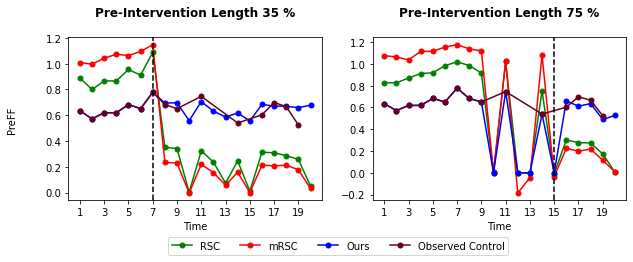

In [12]:
interv_times=[7,15]
fig, big_axes = plt.subplots(figsize=(10,3) , nrows=1, ncols=2, sharey=True) 
for title, big_ax in zip(['Pre-Intervention Length 35 %','Pre-Intervention Length 75 %'], big_axes):
    big_ax.set_title(f'{title}\n', fontweight='semibold')
    big_ax.set_frame_on(False)
    big_ax.axis('off')


for i in range(2):
    x_full = np.arange(20)+1
    mrsc_all = np.append(mrsc_pre_preds[i][:interv_times[i]],mrsc_preds[i],axis=0)
    print(mrsc_all.shape)
    rsc_all = np.append(rsc_pre_preds[i],rsc_preds[i],axis=0)
    mask_this =(1-mask[0,:,0])>0
    x = x_full[mask_this]
    xint = [i for i in range(1,20,2)]
    xlabels = [str(i) for i in range(1,20,2)]
    a=fig.add_subplot(1,2,i+1)
    a.set_xticks(xint,minor=False)
    a.plot(x_full,rsc_all,'og-',label='RSC',markersize=5)
    a.plot(x_full,mrsc_all,'or-',label='mRSC',markersize=5)
    a.plot(x_full,dsc_preds[i],'ob-',label='Ours',markersize=5)
    a.plot(x,actual[i][mask_this],'xkcd:maroon',marker='o',label='Observed Control',markersize=5)
   
   
    plt.axvline(x =interv_times[i],ymin=0, ymax =1 ,linestyle='--',color='black')
    
    #a.legend(loc='upper right')
    a.set_xlabel('Time')
    #a.legend(ncol=4,bbox_to_anchor=(0.5,1), loc = 'lower center')
    
fig.text(0.04, 0.5, 'PreFF', va='center', rotation='vertical')
handles, labels = a.get_legend_handles_labels()
fig.legend(handles, labels, ncol=4,loc='lower center',bbox_to_anchor=(0.5,-0.15))
plt.savefig(f'./figs/asthma.pdf',bbox_inches='tight')